In [1]:
# Instalando conda (mamba)
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
# Instalando pacotes necessários
!mamba install -c conda-forge cartopy siphon metpy imgaug
!apt-get -qq install libproj-dev libgeos-dev
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install pyyaml==5.4.1


Looking for: ['cartopy', 'siphon', 'metpy', 'imgaug']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   4%
conda-forge/noarch    22%[+] 0.3s
conda-forge/linux-64  13%
conda-forge/noarch    45%[+] 0.4s
conda-forge/linux-64  28%
conda-forge/noarch    67%[+] 0.5s
conda-forge/linux-64  32%
conda-forge/noarch    89%[+] 0.6s
conda-forge/linux-64  37%
conda-forge/noarch   100%conda-forge/noarch                                
[+] 0.7s
conda-forge/linux-64  42%[+] 0.8s
conda-forge/linux-64  60%[+] 0.9s
conda-forge/linux-64  70%[+] 1.0s
conda-forge/linux-64  89%conda-forge/linux-64                              

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - cartopy
   - siphon
   - metpy
   - imgaug
   - ca-certificates
   - certifi
   - openssl


  Package                                    Version  Build                   

In [2]:
# A whole bunch of imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from netCDF4 import num2date
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr
from datetime import datetime
import numpy as np
import numpy.ma as ma
from metpy.io import GiniFile
from metpy.plots.ctables import registry
from metpy.units import units
import metpy.calc as mpcalc

In [19]:
dt = datetime(2024, 6, 5, 12)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
#base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_onedeg_ana/GFS_Global_onedeg_ana_'
#cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/GFS_Global_0p25deg_ana_'
cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
ncss = cat.datasets[0].subset()

# Setando
nivel_vento = 850
lat_sul = -67.5 #-30
lat_norte = 30
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# First get wind components data
query_wind = ncss.query()
query_wind.variables('u-component_of_wind_isobaric',
                     'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
query_wind.vertical_level(nivel_vento * 100)
query_wind.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_wind = ncss.get_data(query_wind)

# Second get Geopotential height data because it has a different number of levels
query_hght = ncss.query()
query_hght.variables('Pressure_reduced_to_MSL_msl').add_lonlat().accept('netcdf')
query_hght.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_hght = ncss.get_data(query_hght)

In [20]:
# Tem que fazer esta alteração para conseguir plotar o vento
lon =  data_wind.variables['longitude'][:]
for i in range(len(lon)):
    if lon[i]>180:
        lon[i] = lon[i]-360

In [21]:
# Grab MSLP and smooth, use MetPy Units module for conversion
emsl_var = data_hght.variables['Pressure_reduced_to_MSL_msl']
EMSL = units.Quantity(emsl_var[:], emsl_var.units).to('hPa')
mslp = gaussian_filter(EMSL[0], sigma=1.0)

uwnd_nivel = data_wind.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd_nivel = data_wind.variables['v-component_of_wind_isobaric'][:].squeeze()

U_nivel = units('m/s') * ndimage.gaussian_filter(uwnd_nivel, sigma=1, order=0)
V_nivel = units('m/s') * ndimage.gaussian_filter(vwnd_nivel, sigma=1, order=0)

#lon = data_hght.variables['lon'][:]
lat = data_hght.variables['latitude'][:]
time = data_hght.variables[data_hght.variables['Pressure_reduced_to_MSL_msl'].dimensions[0]]
vtime = num2date(time[:], time.units)

In [22]:
# lev hPa divergence
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

In [23]:
div_nivel = mpcalc.divergence(U_nivel, V_nivel, dx=dx, dy=dy)

In [24]:
div_nivel = gaussian_filter(div_nivel, 4)
#Quero somente os valores negativos da divergencia
mask_div = ma.masked_greater_equal(div_nivel, 0).mask
div_nivel[mask_div] = np.nan

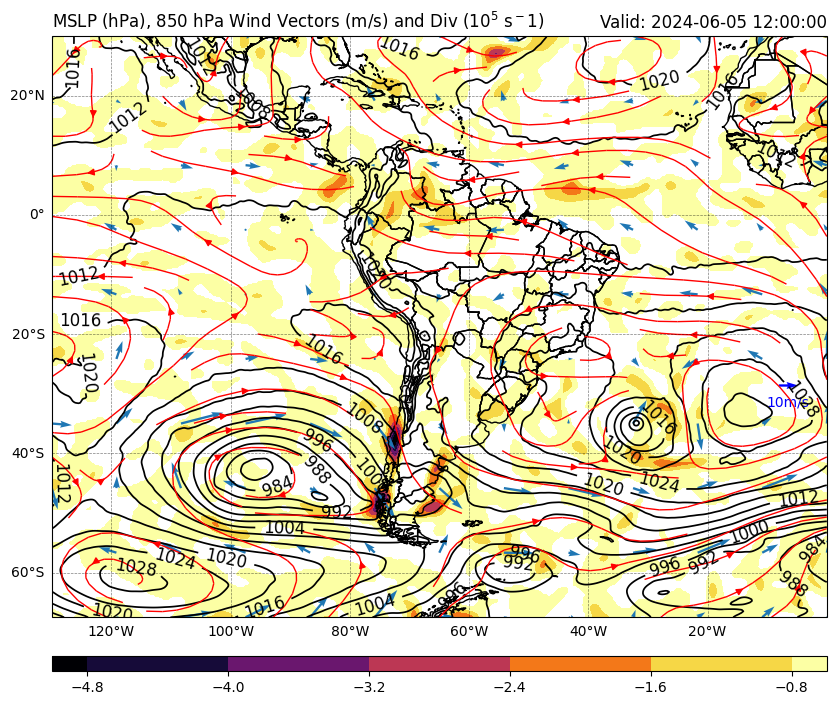

In [25]:
# Create the figure
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plot MSLP
clevmslp = np.arange(800., 1120., 4)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())
cs = ax.contour(lon, lat,mslp, clevmslp, colors='black', linewidths=1.25,linestyles='solid',transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=12, colors='black', inline=1, inline_spacing=8,
          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot the colorfill of divergence, scaled 10^5 every 1 s^1
cs1 = ax.contourf(lon, lat, div_nivel*1e5, cmap='inferno',
                  extend='both', transform=datacrs)
plt.colorbar(cs1, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)

uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='tab:blue',regrid_shape=10,
          width=0.003, scale = 400, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uv,                     #Incoming quiver handle
             X=0.95, Y = 0.4,       #Determine the location of label, all limited to [0,1]
             U = 10,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='10m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'b',labelcolor = 'b', #Arrow color + label color
             )
ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='red', linewidth=1, cmap='autumn')
ax.set_title(f'MSLP (hPa), {nivel_vento} hPa Wind Vectors (m/s) and Div ($10^5$ s$^{-1}$)', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
plt.savefig("ZCIT_LC925_Div925.png", dpi=600, bbox_inches="tight")